# MINTILO AI

An open source project dedicated to utilizing Python and machine learning techniques to provide insights for policy makers in eradicating child mortality in developing countries. By analyzing data from DHS surveys, MINTILO AI identifies risk factors associated with child mortality, leveraging artificial intelligence to contribute to the collective efforts in improving child survival rates.

Copyright © 2023 Kofiya Technologies

# 1. Load data

In [1]:
# === Import dependence
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# === Config
DIR_PROJ = r"D:\PycharmProjects\mintilo-ai"
DIR_INPUT_DATA = os.path.join(DIR_PROJ, "data")
DIR_MODELS = os.path.join(DIR_PROJ, "models")

In [3]:
# Load data     ####################################################################################################################
filepath_data = os.path.join(DIR_INPUT_DATA, "processed_mintilo_ai_community_version.csv")

with open(filepath_data, 'rb') as fp:
    df = pd.read_csv(fp)

In [4]:
# Check data shape
df.shape

(8755, 22)

In [5]:
# Check loaded data
skip_vars_display = ['cluster_number', 'household_number', 'respondent_line_number', 'toilet_facility_type', 
                     'contraceptive_method_current', 'water_source_drinking']

# df.pipe(lambda x: x.drop(columns=skip_vars_display)).head()  # DISABLED for data privacy reason!

# 2. Explore data (EDA)

In [6]:
# Import library
from ydata_profiling import ProfileReport

In [7]:
# Generate EDA report
profile_report = ProfileReport(df, title="DHS U5 Mortality", minimal=True)

In [8]:
# # Display EDA report  # DISABLED for data privacy reason!
# profile_report.to_notebook_iframe()

# 3. Build Machine Learning (ML) models

In [9]:
# Derive label / target variable  ###################################################################
df['HasChildDiedU5'] = np.where(df['is_child_alive'] == 'yes', 
                                0, 
                                np.where((df['is_child_alive'] == 'no') & (df['age_child_months'] <= 60),
                                         1,
                                         -999))


# # Sanity checks
# df[['is_child_alive', 'age_child_months', 'HasChildDiedU5']]

In [10]:
# # Further sanity checks
# df['is_child_alive'].value_counts()

In [11]:
# # Further sanity checks
# df['HasChildDiedU5'].value_counts()

In [12]:
# # Further sanity checks
# df['HasChildDiedU5'].unique()

In [13]:
# Drop old variable that is used to compute the target / label variable
df.drop(['is_child_alive'], axis='columns', inplace=True)

df.shape

(8755, 22)

## 3.1 Split data into training / validation sets

In [14]:
# Get label and features  ##########################################################################
X = df.drop(['HasChildDiedU5', 
            'survey_country', 'survey_year',
            'cluster_number', 'household_number', 'respondent_line_number'], axis='columns')
y = df[['HasChildDiedU5']]

In [15]:
# # Check data - DISABLED for data privacy reason!
# skip_vars_display = ['toilet_facility_type', 'contraceptive_method_current', 'water_source_drinking']

# X.pipe(lambda x: x.drop(columns=skip_vars_display)).head()

In [16]:
# y.head()

In [17]:
# # Get list of categorical and numeric features  ###################################################
# X.pipe(lambda x: x.drop(columns=skip_vars_display)).info()

In [18]:
features_cat = X.select_dtypes(include='object').columns.tolist()
features_num = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

# print("Categorical Features:", features_cat)
# print("\nNumerical Features:", features_num)

In [19]:
# Split data into training and validation sets  #################################################
from sklearn.model_selection import train_test_split

RANDOM_STATE = 101
TEST_SIZE = 0.20

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, 
                                                  test_size=TEST_SIZE, random_state=RANDOM_STATE)

# Sanity checks
print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('\n')
print('X_val', X_val.shape)
print('y_val', y_val.shape)
print('\n')
print('Mortality rate (TRAIN):\n', y_train['HasChildDiedU5'].value_counts(dropna=False, normalize=True).round(2) * 100)
print('\nMortality rate (VAL):\n', y_val['HasChildDiedU5'].value_counts(dropna=False, normalize=True).round(2) * 100)

X_train (7004, 16)
y_train (7004, 1)


X_val (1751, 16)
y_val (1751, 1)


Mortality rate (TRAIN):
 0    94.0
1     6.0
Name: HasChildDiedU5, dtype: float64

Mortality rate (VAL):
 0    94.0
1     6.0
Name: HasChildDiedU5, dtype: float64


## 3.2 Impute missing values

In [20]:
# Get data by feature type
X_train_cat = X_train[features_cat]
X_val_cat = X_val[features_cat]

X_train_num = X_train[features_num]
X_val_num = X_val[features_num]

In [21]:
# X_train_cat.pipe(lambda x: x.drop(columns=skip_vars_display)).head()  # DISABLED for data privacy reason!

In [22]:
# X_train_num.head()  # DISABLED for data privacy reason!

In [23]:
# # Check missing data in categorical features  # DISABLED for data privacy reason!
# # IMPORTANT - No missing data!
# X_train_cat.isnull().sum()

In [24]:
# # Check missing data in numeric features  # DISABLED for data privacy reason!
# # IMPORTANT - Two features have missing data!
# X_train_num.isnull().sum()

In [25]:
# Impute categorical features     ###############################################################################################################
# IMPORTANT - Although no missing data here, we show the framework for imputing missing data!

from sklearn.impute import SimpleImputer

# Apply imputer
imputer_cat = SimpleImputer(strategy='most_frequent')

X_train_cat_imputed = imputer_cat.fit_transform(X_train_cat)
X_train_cat_imputed = pd.DataFrame(X_train_cat_imputed, columns=X_train_cat.columns)

# # Sanity checks
# print('Number of missing values (BEFORE):\n', X_train_cat.isnull().sum())
# print('\nNumber of missing values (AFTER):\n', X_train_cat_imputed.isnull().sum())

In [26]:
# Impute validation set as well
X_val_cat_imputed = imputer_cat.transform(X_val_cat)
X_val_cat_imputed = pd.DataFrame(X_val_cat_imputed, columns=X_val_cat.columns)

# # Sanity checks
# print('Number of missing values (BEFORE):\n', X_val_cat.isnull().sum())
# print('\nNumber of missing values (AFTER):\n', X_val_cat_imputed.isnull().sum())

In [27]:
# Impute numeric features     ###############################################################################################################
imputer_num = SimpleImputer(strategy='median')

X_train_num_imputed = imputer_num.fit_transform(X_train_num)
X_train_num_imputed = pd.DataFrame(X_train_num_imputed, columns=X_train_num.columns)

# # Sanity checks
# print('Number of missing values (BEFORE):\n', X_train_num.isnull().sum())
# print('\nNumber of missing values (AFTER):\n', X_train_num_imputed.isnull().sum())

In [28]:
# Impute validation set as well
X_val_num_imputed = imputer_num.transform(X_val_num)
X_val_num_imputed = pd.DataFrame(X_val_num_imputed, columns=X_val_num.columns)

# # Sanity checks
# print('Number of missing values (BEFORE):\n', X_val_num.isnull().sum())
# print('\nNumber of missing values (AFTER):\n', X_val_num_imputed.isnull().sum())

In [29]:
# Save imputers for future use   ####################################################################################################
import pickle
    
filepath_imputer_cat = os.path.join(DIR_MODELS, 'imputer_cat.pkl')
with open(filepath_imputer_cat, 'wb') as pkl:
    pickle.dump(imputer_cat, pkl)

filepath_imputer_num = os.path.join(DIR_MODELS, 'imputer_num.pkl')
with open(filepath_imputer_num, 'wb') as pkl:
    pickle.dump(imputer_num, pkl)

## 3.3 Feature scaling or normalization for numeric features

In [30]:
# Feature scaling for numeric variables   ############################################################################################
from sklearn.preprocessing import StandardScaler

# Apply feature scaling
scaler = StandardScaler()

X_train_num_scaler = scaler.fit_transform(X_train_num_imputed)
X_train_num_scaler = pd.DataFrame(X_train_num_scaler, columns=X_train_num_imputed.columns)

# # Sanity checks
# X_train_num_scaler.head()

In [31]:
# Scale validation data as well
X_val_num_scaler = scaler.transform(X_val_num_imputed)
X_val_num_scaler = pd.DataFrame(X_val_num_scaler, columns=X_val_num_imputed.columns)

# # Sanity checks
# X_val_num_scaler.head()

In [32]:
# Save scaler for later use
filepath_scaler = os.path.join(DIR_MODELS, 'scaler.pkl')
with open(filepath_scaler, 'wb') as pkl:
    pickle.dump(scaler, pkl)

## 3.4 One-Hot Encoding for categorical features

In [33]:
# # Check data before Encoding!
# X_train_cat_imputed.pipe(lambda x: x.drop(columns=skip_vars_display)).head()

In [34]:
# Import library
from sklearn.preprocessing import OneHotEncoder

# Apply One-Hot Encoding
encoder = OneHotEncoder(handle_unknown='ignore')

X_train_cat_encoded = encoder.fit_transform(X_train_cat_imputed)
X_train_cat_encoded = pd.DataFrame(X_train_cat_encoded.toarray(), columns=encoder.get_feature_names_out(features_cat))

# Sanity checks after Encoding!
skip_vars_display = [col for col in X_train_cat_encoded.columns if col.startswith("toilet")]

# X_train_cat_encoded.drop(columns=skip_vars_display).head()

In [35]:
# Encode validation data set as well
X_val_cat_encoded = encoder.transform(X_val_cat_imputed)
X_val_cat_encoded = pd.DataFrame(X_val_cat_encoded.toarray(), columns=encoder.get_feature_names_out(features_cat))

# # Sanity checks after Encoding!
# X_val_cat_encoded.drop(columns=skip_vars_display).head()

In [36]:
# Save encoder for later use
filepath_encoder = os.path.join(DIR_MODELS, 'encoder.pkl')
with open(filepath_encoder, 'wb') as pkl:
    pickle.dump(encoder, pkl)

## 3.5 Combine processed data

In [37]:
# Combine data - TRAIN
X_train_ready = pd.concat([X_train_num_scaler, X_train_cat_encoded], axis='columns')

print('X_train_ready', X_train_ready.shape)
print('\n')

# X_train_ready.drop(columns=skip_vars_display).head()

X_train_ready (7004, 79)




In [38]:
# Combine data - VALIDATION
X_val_ready = pd.concat([X_val_num_scaler, X_val_cat_encoded], axis='columns')

print('X_val_ready', X_val_ready.shape)
print('\n')

# X_val_ready.drop(columns=skip_vars_display).head()

X_val_ready (1751, 79)




## 3.6 Build ML models

In [39]:
# Convert label from Pandas data frame to numpy for ML training
y_train = y_train.to_numpy().flatten()
y_val = y_val.to_numpy().flatten()

In [40]:
y_train.shape

(7004,)

In [41]:
type(y_train)

numpy.ndarray

In [42]:
# y_train[:100]

In [43]:
# # Sanity checks for distribution of child deaths
# np.unique(y_train, return_counts=True)

In [44]:
# np.unique(y_val, return_counts=True)

In [45]:
# df['HasChildDiedU5'].unique()

In [46]:
# np.isnan(y_train).any()

pd.isnull(y_train).any()

False

### General Linear Model (Logistic regression model)

In [47]:
# Import library
from sklearn.linear_model import LogisticRegression

# Train ML model
RANDOM_STATE = 101

model_lr = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)

model_lr.fit(X_train_ready, y_train)

LogisticRegression(max_iter=1000, random_state=101)

In [48]:
# Evaluate model
y_pred_lr = model_lr.predict(X_val_ready)

In [49]:
# y_pred_lr[:100]

In [50]:
# Evaluate model performance using Confusion matrix and ROC #################################################################################################
from sklearn.metrics import confusion_matrix

# Get confusion matrix
cm = confusion_matrix(y_true=y_val, y_pred=y_pred_lr)

# print(cm)

In [51]:
# # Display confusion matrix  # DISABLED for data privacy reason!
# from sklearn.metrics import ConfusionMatrixDisplay

# cm_lr = confusion_matrix(y_true=y_val, y_pred=y_pred_lr)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=model_lr.classes_)
# disp.plot()

# plt.show()

In [52]:
# Calculate AUC
from sklearn.metrics import roc_auc_score

# Calculate prediction probability before calculating AUC
y_pred_prob_lr = model_lr.predict_proba(X_val_ready)

# print('y_pred_prob_lr\n', y_pred_prob_lr[:10])

In [53]:
auc_lr = roc_auc_score(y_val, y_pred_prob_lr[:, -1])
auc_lr

0.8777429110671487

In [54]:
# Plot ROC
from sklearn.metrics import roc_curve

fpr_lr, tpr_lr, th_lr = roc_curve(y_val, y_pred_prob_lr[:, -1])

In [55]:
# Custom function to plot ROC curve
def plot_roc_curve(fpr_list, tpr_list, label_list=None, auc_list=None):  
    assert isinstance(fpr_list, list), 'Please pass FPR in a list, e.g., [fpr_lr]'
    assert isinstance(tpr_list, list), 'Please pass TPR in a list, e.g., [fpr_lr]'
    
    if label_list is not None:
        assert isinstance(label_list, list), 'Please pass label in a list, e.g., [label_lr]'
        
    if auc_list is not None:
        assert isinstance(auc_list, list), 'Please pass AUC in a list, e.g., [auc_lr]'
    
    if label_list is None:
        label_list = [None] * len(fpr_list)
        
    if auc_list is None:
        auc_list = [None] * len(fpr_list)
        
    for fpr, tpr, label, auc in zip(fpr_list, tpr_list, label_list, auc_list):
        plt.plot(fpr, tpr, linewidth=2, 
                 label=''.join([label, ' (auc = ', str(round(auc * 100, 1)), '%)']) if label is not None else None,
                )
        plt.plot([0, 1], [0, 1], color='0.8')

        plt.xlabel("FPR (1 - Specificity)")
        plt.ylabel("TPR (Sensitivity)")
        
        if label is not None and auc is not None:
            plt.legend()

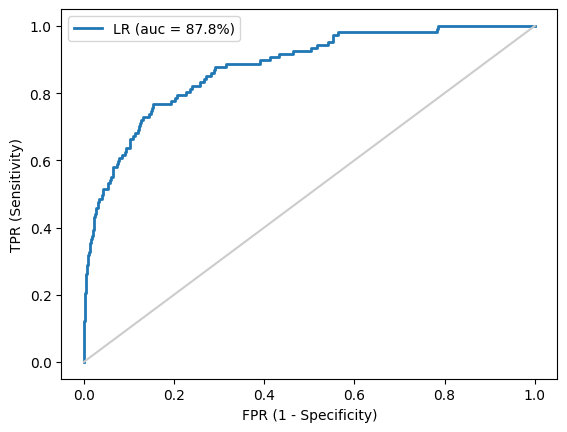

In [56]:
# Plot ROC for logistic regression model
plot_roc_curve([fpr_lr], [tpr_lr], label_list=['LR'], auc_list=[auc_lr])

## K-nearest Neighbors Model

In [57]:
# Load library
from sklearn.neighbors import KNeighborsClassifier

# Set Hyperparameters
N_NEIGHBORS = 10

# Train model
model_knn = KNeighborsClassifier(n_neighbors=N_NEIGHBORS)

model_knn.fit(X_train_ready, y_train)

KNeighborsClassifier(n_neighbors=10)

In [58]:
# Evaluate model
y_pred_knn = model_knn.predict(X_val_ready)

In [59]:
# # Display confusion matrix  # DISABLED for data privacy reason!
# cm_knn = confusion_matrix(y_true=y_val, y_pred=y_pred_knn)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_knn, display_labels=model_knn.classes_)
# disp.plot()

# plt.show()

In [60]:
# Calculate AUC
y_pred_prob_knn = model_knn.predict_proba(X_val_ready)

auc_knn = roc_auc_score(y_val, y_pred_prob_knn[:, -1])
auc_knn

0.7811697023444073

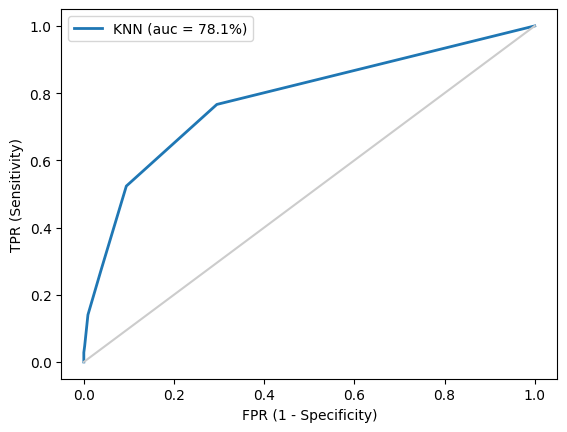

In [61]:
# ROC for KNN
fpr_knn, tpr_knn, th_knn = roc_curve(y_val, y_pred_prob_knn[:, -1])

plot_roc_curve([fpr_knn], [tpr_knn], label_list=['KNN'], auc_list=[auc_knn])

### Random Forest Model

In [62]:
# Load library
from sklearn.ensemble import RandomForestClassifier

# Set Hyperparameters
N_TREES = 250
N_DEPTH = 3

# Train model
model_rf = RandomForestClassifier(n_estimators=N_TREES, max_depth=N_DEPTH, random_state=RANDOM_STATE)

model_rf.fit(X_train_ready, y_train)

RandomForestClassifier(max_depth=3, n_estimators=250, random_state=101)

In [63]:
# Evaluate model
y_pred_rf = model_rf.predict(X_val_ready)

In [64]:
# # Display confusion matrix  # DISABLED for data privacy reason!
# cm_rf = confusion_matrix(y_true=y_val, y_pred=y_pred_rf)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=model_rf.classes_)
# disp.plot()

# plt.show()

In [65]:
# Calculate AUC
y_pred_prob_rf = model_rf.predict_proba(X_val_ready)

auc_rf = roc_auc_score(y_val, y_pred_prob_rf[:, -1])
auc_rf

0.8401778202242081

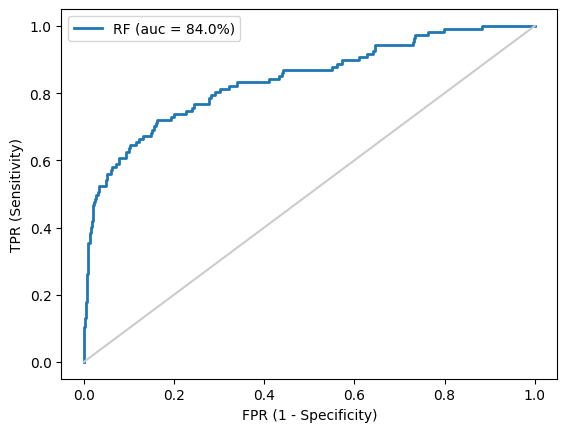

In [66]:
# ROC for RF
fpr_rf, tpr_rf, th_rf = roc_curve(y_val, y_pred_prob_rf[:, -1])

plot_roc_curve([fpr_rf], [tpr_rf], label_list=['RF'], auc_list=[auc_rf])

### Gradient Boosting - Catboost

In [67]:
# Import library
from catboost import CatBoostClassifier

# Set Hyperparameters
N_TREES = 250
LEARNING_RATE = 0.001
N_DEPTH = 5

# Train model
model_cb = CatBoostClassifier(iterations=N_TREES,
                              learning_rate=LEARNING_RATE,
                              depth=N_DEPTH, 
                              verbose=0)
# Fit model
model_cb.fit(X_train_ready, y_train)

In [68]:
# Evaluate model
y_pred_cb = model_cb.predict(X_val_ready)

In [69]:
# # Display confusion matrix
# cm_cb = confusion_matrix(y_true=y_val, y_pred=y_pred_cb)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_cb, display_labels=model_cb.classes_)
# disp.plot()

# plt.show()

In [70]:
# Calculate AUC
y_pred_prob_cb = model_cb.predict_proba(X_val_ready)

auc_cb = roc_auc_score(y_val, y_pred_prob_cb[:, -1])
auc_cb

0.8951326829933829

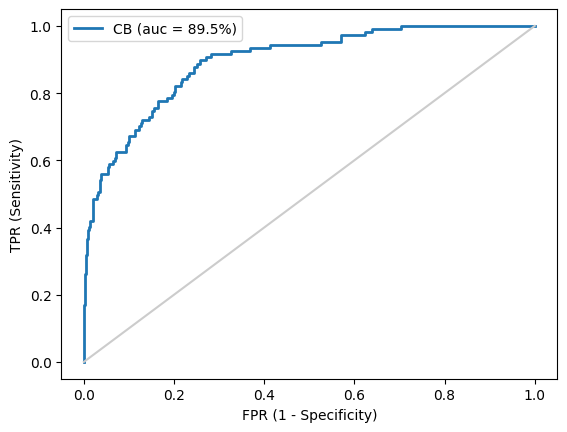

In [71]:
# ROC for RF
fpr_cb, tpr_cb, th_cb = roc_curve(y_val, y_pred_prob_cb[:, -1])

plot_roc_curve([fpr_cb], [tpr_cb], label_list=['CB'], auc_list=[auc_cb])

## Compare model performance for different ML algorithms

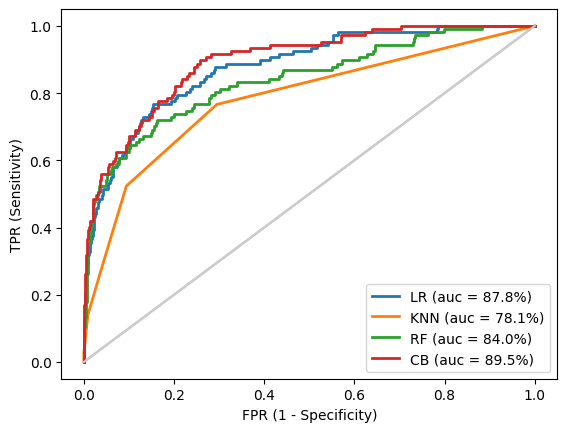

In [72]:
# Compare models using ROC curve
plot_roc_curve([fpr_lr, fpr_knn, fpr_rf, fpr_cb], 
               [tpr_lr, tpr_knn, tpr_rf, tpr_cb], 
               label_list=['LR', 'KNN', 'RF', 'CB'], 
               auc_list=[auc_lr, auc_knn, auc_rf, auc_cb])

# 4. Improve model performance

## 4.1 Address class imbalance

In [73]:
y_train_df = pd.DataFrame({
    'target': y_train
})

# y_train_df

In [74]:
# combine X_train and y_train into a single DataFrame
y_train_df = pd.DataFrame({
    'target': y_train
})

train_data = pd.concat([X_train_ready, y_train_df], axis=1)

# separate instances of each class
negative_class = train_data[train_data.target==0]
positive_class = train_data[train_data.target==1]

# randomly undersample the majority class
from sklearn.utils import resample

RANDOM_STATE = 101

negative_class_downsampled = resample(negative_class,
                                       replace=False,     # sample without replacement
                                       n_samples=len(positive_class),  # match minority class
                                       random_state=RANDOM_STATE)   # reproducible results

# combine minority class and downsampled majority class
downsampled = pd.concat([negative_class_downsampled, positive_class])
print('downsampled', downsampled.shape)

# separate input features and target variable
X_train_downsampled = downsampled.drop('target', axis=1)
y_train_downsampled = downsampled['target']

downsampled (860, 80)


In [75]:
y_train_downsampled.value_counts(normalize=True)

0    0.5
1    0.5
Name: target, dtype: float64

In [76]:
# Re-train LR after downsampling   ########################################################################################################################

# Train
RANDOM_STATE = 101
model_lr_downsampled = LogisticRegression(random_state=RANDOM_STATE, max_iter=1000)
model_lr_downsampled.fit(X_train_downsampled, y_train_downsampled)

# Evaluate model
y_pred_lr = model_lr_downsampled.predict(X_val_ready)

# Evaluate
y_pred_prob_lr = model_lr_downsampled.predict_proba(X_val_ready)
auc_lr_after = roc_auc_score(y_val, y_pred_prob_lr[:, -1])
auc_lr_after

0.875179070877959

In [77]:
auc_lr

0.8777429110671487

In [78]:
# # Display confusion matrix  # DISABLED for data privacy reason!
# cm_lr_after = confusion_matrix(y_true=y_val, y_pred=y_pred_lr)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm_lr_after, display_labels=model_lr_downsampled.classes_)
# disp.plot()

# plt.show()

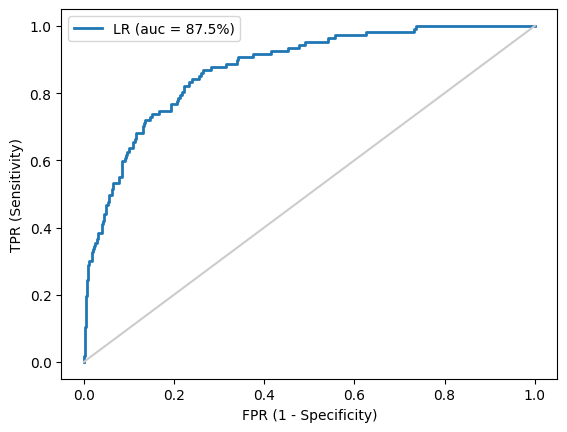

In [79]:
# ROC
fpr_lr, tpr_lr, th_lr = roc_curve(y_val, y_pred_prob_lr[:, -1])

plot_roc_curve([fpr_lr], [tpr_lr], label_list=['LR'], auc_list=[auc_lr_after])

## 5. Feature Importance

In [80]:
# Calculate feature importance
feature_importance = abs(model_lr.coef_[0])
feature_importance = 100.0 * (feature_importance / feature_importance.max())

# feature_importance

In [81]:
# # Custom function for Feature Importance for LR  # DISABLED for data privacy reason!
# import numpy as np

# def plot_feature_importance_lr(lr_model, colnames_x, threshold_importance=None):
#     # Compute feature importance
#     feature_importance = abs(lr_model.coef_[0])
#     feature_importance = 100.0 * (feature_importance / feature_importance.max())

#     # Keep strong importance
#     if threshold_importance is not None:
#         feature_importance = feature_importance[feature_importance > threshold_importance]

#     # Plot importance
#     idx_sorted = np.argsort(feature_importance)
#     pos = np.arange(idx_sorted.shape[0]) + 0.5

#     fig = plt.figure()
#     ax = fig.add_subplot(1, 1, 1)
    
#     ax.barh(pos, feature_importance[idx_sorted], align='center')
#     ax.set_yticks(pos)
#     ax.set_yticklabels(np.array(X.columns)[idx_sorted], fontsize=12)
#     ax.set_xlabel('Relative Feature Importance')
    
#     plt.tight_layout()   
#     plt.show()

In [82]:
# plot_feature_importance_lr(model_lr, colnames_x=X_train_ready.columns, threshold_importance=15)

In [83]:
# Save model for later use   ##################################################################################################################

# Import library
import joblib

# Save model
filepath_model = os.path.join(DIR_MODELS, 'model_lr.pkl')
with open(filepath_model, 'wb') as fp:
    joblib.dump(model_lr_downsampled, fp)

# 6. Load saved model and do predictions

In [84]:
# Load saved model
filepath_saved_model = os.path.join(DIR_MODELS, 'model_lr.pkl')
loaded_model = joblib.load(filepath_saved_model)

In [85]:
loaded_model

LogisticRegression(max_iter=1000, random_state=101)

In [86]:
# Do prediction
y_pred = loaded_model.predict(X_val_ready)

In [87]:
# y_pred

In [88]:
# len(y_pred)

In [89]:
# np.unique(y_pred, return_counts=True)